In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import xgboost as xgb

In [2]:
CIF = pd.read_csv('data/TBN_CIF.csv',index_col='CUST_NO')  # 顧客基本資料
RECENT_DT = pd.read_csv('data/TBN_RECENT_DT.csv', na_values='a',index_col='CUST_NO')  #近期投資行為

CUST_BEHAVIOR = pd.read_csv('data/TBN_CUST_BEHAVIOR.csv', index_col='CUST_NO') #顧客瀏覽網頁行為
CUST_BEHAVIOR_raw = pd.read_csv('data/TBN_CUST_BEHAVIOR.csv') #顧客瀏覽網頁行為


CC_APPLY = pd.read_csv('data/TBN_CC_APPLY.csv') # 信用卡, priority 10
FX_TXN = pd.read_csv('data/TBN_FX_TXN.csv')    # 外匯, priority 1
LN_APPLY = pd.read_csv('data/TBN_LN_APPLY.csv')  # 信貸, priority 20
WM_TXN = pd.read_csv('data/TBN_WM_TXN.csv')  # 信託, priority 20

TBN = pd.read_csv('data/TBN_Y_ZERO.csv',index_col='CUST_NO')  # 信託, priority 20

In [3]:
# 將
CUST_BEHAVIOR_new = pd.concat((CUST_BEHAVIOR,TBN['CC_IND']), axis=1, join_axes=[CUST_BEHAVIOR.index])
CUST_BEHAVIOR_new = CUST_BEHAVIOR_new[CUST_BEHAVIOR_new['CC_IND']==0]

In [4]:
CUST_BEHAVIOR_new.shape

(513803, 3)

In [5]:
CUST_BEHAVIOR_new.groupby(CUST_BEHAVIOR_new.index,sort=False).max().shape

(30000, 3)

In [6]:
print('CIF shape:( %i, %i)'%(CIF.shape[0],CIF.shape[1]))
print('CUST_BEHAVIOR shape:( %i, %i)'%(CUST_BEHAVIOR.shape[0],CUST_BEHAVIOR.shape[1]))
print('CUST_BEHAVIOR_raw shape:( %i, %i)'%(CUST_BEHAVIOR_raw.shape[0],CUST_BEHAVIOR_raw.shape[1]))
print('RECENT_DT. shape:( %i, %i)'%(RECENT_DT.shape[0],RECENT_DT.shape[1]))
print('CC_APPLY shape:( %i, %i)'%(CC_APPLY.shape[0],CC_APPLY.shape[1]))
print('FX_TXN shape:( %i, %i)'%(FX_TXN.shape[0],FX_TXN.shape[1]))
print('LN_APPLY shape:( %i, %i)'%(LN_APPLY.shape[0],LN_APPLY.shape[1]))
print('WM_TXN shape:( %i, %i)'%(WM_TXN.shape[0],WM_TXN.shape[1]))
print('TBN shape:( %i, %i)'%(TBN.shape[0],TBN.shape[1]))

CIF shape:( 187679, 7)
CUST_BEHAVIOR shape:( 2209864, 2)
CUST_BEHAVIOR_raw shape:( 2209864, 3)
RECENT_DT. shape:( 195000, 4)
CC_APPLY shape:( 54393, 2)
FX_TXN shape:( 507185, 3)
LN_APPLY shape:( 6741, 4)
WM_TXN shape:( 36763, 5)
TBN shape:( 30000, 4)


In [7]:
print(CIF.head())
CIF.loc['W7ADZSWYXEMHB7JQ']

                  AGE  CHILDREN_CNT  CUST_START_DT  EDU_CODE GENDER_CODE  \
CUST_NO                                                                    
UFUIMEGMK2KTIWI4    1           NaN            2.0       NaN         NaN   
3HJN2X_LGBHBKILI    3           0.0         9393.0       NaN         NaN   
MNEZK2O3OE-JHYBW    4           0.0         2912.0       3.0           M   
W7ADZSWYXEMHB7JQ    4           0.0         8332.0       5.0           M   
ODB6BA6ORHL2UYZE    4           0.0          744.0       3.0           M   

                  INCOME_RANGE_CODE  WORK_MTHS  
CUST_NO                                         
UFUIMEGMK2KTIWI4                NaN        NaN  
3HJN2X_LGBHBKILI                1.0        NaN  
MNEZK2O3OE-JHYBW                2.0        2.0  
W7ADZSWYXEMHB7JQ                2.0        1.0  
ODB6BA6ORHL2UYZE                2.0        1.0  


AGE                     4
CHILDREN_CNT            0
CUST_START_DT        8332
EDU_CODE                5
GENDER_CODE             M
INCOME_RANGE_CODE       2
WORK_MTHS               1
Name: W7ADZSWYXEMHB7JQ, dtype: object

In [8]:
print(RECENT_DT.head())
RECENT_DT['CC_RECENT_DT']=RECENT_DT['CC_RECENT_DT'].fillna(0)
RECENT_DT['FX_RECENT_DT']=RECENT_DT['FX_RECENT_DT'].fillna(0)
RECENT_DT['LN_RECENT_DT']=RECENT_DT['LN_RECENT_DT'].fillna(0)
RECENT_DT['WM_RECENT_DT']=RECENT_DT['WM_RECENT_DT'].fillna(0)
print('CC_RECENT_DT: %.1f, %.1f '%(min(RECENT_DT['CC_RECENT_DT']), max(RECENT_DT['CC_RECENT_DT'])))
print('FX_RECENT_DT: %.1f, %.1f '%(min(RECENT_DT['FX_RECENT_DT']), max(RECENT_DT['FX_RECENT_DT'])))
print('LN_RECENT_DT: %.1f, %.1f '%(min(RECENT_DT['LN_RECENT_DT']), max(RECENT_DT['LN_RECENT_DT'])))
print('WM_RECENT_DT: %.1f, %.1f '%(min(RECENT_DT['WM_RECENT_DT']), max(RECENT_DT['WM_RECENT_DT'])))

                  CC_RECENT_DT  FX_RECENT_DT  LN_RECENT_DT  WM_RECENT_DT
CUST_NO                                                                 
UTYYSZRISTNCDCGU           NaN           NaN           NaN           NaN
4IKO82Q8ZY2X2VAK           NaN           NaN           NaN           NaN
EP2OI8DQMZFAHBEA        9214.0           NaN           NaN           NaN
83A1N8HQ4CLT56IY        9393.0        9438.0           NaN        9368.0
SURN2CDMNHCL4SJC        7318.0        9445.0           NaN        8154.0
CC_RECENT_DT: 0.0, 9447.0 
FX_RECENT_DT: 0.0, 9447.0 
LN_RECENT_DT: 0.0, 9445.0 
WM_RECENT_DT: 0.0, 9445.0 


In [9]:
print(CUST_BEHAVIOR.head())
print('VISITDATE: %.1f, %.1f '%(min(CUST_BEHAVIOR['VISITDATE']), max(CUST_BEHAVIOR['VISITDATE'])))

                  VISITDATE                                               PAGE
CUST_NO                                                                       
AZTHNWQ_LXMGIMYG       9462      http://www.esunbank.com.tw/gygrt/e2c/iougkjr/
AZTHNWQ_LXMGIMYG       9528  https://www.esunbank.com.tw/gygrt/wgdqth/gsxri...
3PY428CHUQBULFIG       9458  https://www.esunbank.com.tw/edrn/deoxt/rgws-cg...
JVPD1QUJWVLMZU8S       9457  https://www.esunbank.com.tw/edrn/pgusordq/fgpo...
JVPD1QUJWVLMZU8S       9485  https://www.esunbank.com.tw/edrn/pgusordq/fgpo...
VISITDATE: 9448.0, 9567.0 


In [10]:
print(CC_APPLY.head())
print('CC_TXN_DT: %i, %i '%(min(CC_APPLY['TXN_DT']), max(CC_APPLY['TXN_DT'])))

            CUST_NO  TXN_DT
0  8H_N_K5ICM4NU7OG    9519
1  HXD9GCY3SPIYLJS0    9451
2  KSBOZ-TBPUDD9NMO    9502
3  MU8ROCNFDGSL0HJC    9549
4  RGZZAUSNHNXXESM4    9561
CC_TXN_DT: 9448, 9567 


In [11]:
print(FX_TXN.head())
print('FX_TXN_DT: %i, %i '%(min(FX_TXN['TXN_DT']), max(FX_TXN['TXN_DT'])))

            CUST_NO  TXN_DT  FX_TXN_AMT
0  MNEZK2O3OE-JHYBW    9562       26006
1  MNEZK2O3OE-JHYBW    9567       26009
2  MNEZK2O3OE-JHYBW    9557       26793
3  MNEZK2O3OE-JHYBW    9452       25981
4  MNEZK2O3OE-JHYBW    9451       26002
FX_TXN_DT: 9448, 9567 


In [12]:
print(LN_APPLY.head())
print('LN_TXN_DT: %i, %i '%(min(LN_APPLY['TXN_DT']), max(LN_APPLY['TXN_DT'])))

            CUST_NO  TXN_DT   LN_AMT LN_USE
0  JZKEGB1J3FEPXGWA    9455   904731     06
1  TKTH9UXLWDVLA8E4    9472  1218170     01
2  KZ0XPLZI-NGTHTDE    9505  1183088     01
3  BT5INBWYOZQK8CDY    9457   848097     05
4  Z5H7IUX8VPUMWWY8    9473   848097     01
LN_TXN_DT: 9449, 9567 


In [13]:
print(WM_TXN.head())
print('WM_TXN_DT: %i, %i '%(min(WM_TXN['TXN_DT']), max(WM_TXN['TXN_DT'])))

            CUST_NO  TXN_DT  CUST_RISK_CODE  INVEST_TYPE_CODE  WM_TXN_AMT
0  83A1N8HQ4CLT56IY    9476             3.0                 2      270684
1  B8ZNLMVWJOHCJ7LY    9546             3.0                 2      254794
2  -O2NVMT-W0WJHEAQ    9521             3.0                 2      797298
3  NRVZ15KRUYBNVLX0    9490             4.0                 2      439191
4  GAP3CQTQ-3K8OAHM    9513             4.0                 2      137037
WM_TXN_DT: 9449, 9567 


## 1. 訓練資料集時間為 9447+1 (9448) ~ 9447+120 (9567) 之間，共120日之間產品交易/申請資訊．
## 2. 本次比賽是請參賽者預測在9447+121 (9568) ~ 9447+150 (9597) 時間區間內（共30日），顧客在四個產品線CC_IND, FX_IND, LN_IND, WM_IND是否會進行交易，若預測顧客該時間內於任一產品線交易一次以上，該產品線的預測值為1，否則為0．例如: 顧客序號12345，預測信用卡核卡1次，外匯交易2次，沒有信貸申請，信託交易3次，該筆預測資料應為: 12345,1,1,0,1 ．
## 3. TBN_Y_ZERO.csv則是提供給參賽者做為上傳範例資料檔使用，內部預設值是全部為0．

In [14]:
a=LN_APPLY.groupby('CUST_NO', sort=False).max()

In [15]:
a
#a.loc['B8ZNLMVWJOHCJ7LY']

,TXN_DT,LN_AMT,LN_USE
CUST_NO,,,
JZKEGB1J3FEPXGWA,9455,904731,06
TKTH9UXLWDVLA8E4,9472,1218170,01
KZ0XPLZI-NGTHTDE,9505,1183088,01
BT5INBWYOZQK8CDY,9457,848097,05
Z5H7IUX8VPUMWWY8,9473,848097,01
P2R1KVNGH3YVPYCM,9459,848097,06
DOFXDCQNVMEF3ASU,9508,1218170,01
-U0UHX5JPLRKT2HW,9465,828864,14
648T_UNI9J1XFOM0,9470,988495,01


In [16]:
LN = pd.concat((CIF,RECENT_DT), axis=1, join_axes=[RECENT_DT.index], ignore_index=False)
print(LN.loc['SURN2CDMNHCL4SJC'])
#print(WM[WM['CUST_RISK_CODE']>0])
#print(WM[WM['WM_TXN_AMT']>0])
LN.shape

AGE                     4
CHILDREN_CNT            0
CUST_START_DT        4677
EDU_CODE                2
GENDER_CODE             M
INCOME_RANGE_CODE       2
WORK_MTHS               1
CC_RECENT_DT         7318
FX_RECENT_DT         9445
LN_RECENT_DT            0
WM_RECENT_DT         8154
Name: SURN2CDMNHCL4SJC, dtype: object


(195000, 11)

In [17]:


print(max(CUST_BEHAVIOR['VISITDATE']))
CUST_B_over30 = CUST_BEHAVIOR[CUST_BEHAVIOR['VISITDATE']<=(max(CUST_BEHAVIOR['VISITDATE'])-30)]
CUST_B_30_60 = CUST_BEHAVIOR[(CUST_BEHAVIOR['VISITDATE']<=(max(CUST_BEHAVIOR['VISITDATE'])-30)) & (CUST_BEHAVIOR['VISITDATE']>(max(CUST_BEHAVIOR['VISITDATE'])-60))]
CUST_B_60_90 = CUST_BEHAVIOR[(CUST_BEHAVIOR['VISITDATE']<=(max(CUST_BEHAVIOR['VISITDATE'])-60)) & (CUST_BEHAVIOR['VISITDATE']>(max(CUST_BEHAVIOR['VISITDATE'])-90))]
CUST_B_90_120 = CUST_BEHAVIOR[(CUST_BEHAVIOR['VISITDATE']<=(max(CUST_BEHAVIOR['VISITDATE'])-90)) & (CUST_BEHAVIOR['VISITDATE']>(max(CUST_BEHAVIOR['VISITDATE'])-120))]
CUST_B_in30 = CUST_BEHAVIOR[CUST_BEHAVIOR['VISITDATE']>(max(CUST_BEHAVIOR['VISITDATE'])-30)]
print('Over 30 days, max day: %i' %max(CUST_B_over30['VISITDATE']))
print(' 30~60  days, max day: %i' %max(CUST_B_30_60['VISITDATE']))
print(' 60~90  days, max day: %i' %max(CUST_B_60_90['VISITDATE']))
print(' 90~120  days, max day: %i' %max(CUST_B_90_120['VISITDATE']))
print('  in 30 days, min day: %i' %min(CUST_B_in30['VISITDATE']))
#print(CUST_B_over30.shape)
print(CUST_B_30_60.shape)
print(CUST_B_60_90.shape)
print(CUST_B_90_120.shape)
print(CUST_B_in30.shape)

9567
Over 30 days, max day: 9537
 30~60  days, max day: 9537
 60~90  days, max day: 9507
 90~120  days, max day: 9477
  in 30 days, min day: 9538
(649891, 2)
(601314, 2)
(760446, 2)
(198213, 2)


In [18]:

print(max(CUST_BEHAVIOR_raw['VISITDATE']))
CUST_B_over30_raw = CUST_BEHAVIOR_raw[CUST_BEHAVIOR_raw['VISITDATE']<=(max(CUST_BEHAVIOR_raw['VISITDATE'])-30)]
CUST_B_30_60_raw = CUST_BEHAVIOR_raw[(CUST_BEHAVIOR_raw['VISITDATE']<=(max(CUST_BEHAVIOR_raw['VISITDATE'])-30)) & (CUST_BEHAVIOR_raw['VISITDATE']>(max(CUST_BEHAVIOR_raw['VISITDATE'])-60))]
CUST_B_60_90_raw = CUST_BEHAVIOR_raw[(CUST_BEHAVIOR_raw['VISITDATE']<=(max(CUST_BEHAVIOR_raw['VISITDATE'])-60)) & (CUST_BEHAVIOR_raw['VISITDATE']>(max(CUST_BEHAVIOR_raw['VISITDATE'])-90))]
CUST_B_90_120_raw = CUST_BEHAVIOR_raw[(CUST_BEHAVIOR_raw['VISITDATE']<=(max(CUST_BEHAVIOR_raw['VISITDATE'])-90)) & (CUST_BEHAVIOR_raw['VISITDATE']>(max(CUST_BEHAVIOR_raw['VISITDATE'])-120))]
CUST_B_in30_raw = CUST_BEHAVIOR_raw[CUST_BEHAVIOR_raw['VISITDATE']>(max(CUST_BEHAVIOR_raw['VISITDATE'])-30)]
print('Over 30 days, max day: %i' %max(CUST_B_over30_raw['VISITDATE']))
print(' 30~60  days, max day: %i' %max(CUST_B_30_60_raw['VISITDATE']))
print(' 60~90  days, max day: %i' %max(CUST_B_60_90_raw['VISITDATE']))
print(' 90~120  days, max day: %i' %max(CUST_B_90_120_raw['VISITDATE']))
print('  in 30 days, min day: %i' %min(CUST_B_in30_raw['VISITDATE']))
#print(CUST_B_over30.shape)
print(CUST_B_30_60_raw.shape)
print(CUST_B_60_90_raw.shape)
print(CUST_B_90_120_raw.shape)
print(CUST_B_in30_raw.shape)

9567
Over 30 days, max day: 9537
 30~60  days, max day: 9537
 60~90  days, max day: 9507
 90~120  days, max day: 9477
  in 30 days, min day: 9538
(649891, 3)
(601314, 3)
(760446, 3)
(198213, 3)


In [19]:
CUST_BEHAVIOR.shape

(2209864, 2)

In [20]:
#total page count
PAGE_count = CUST_BEHAVIOR.groupby('PAGE').max()
PAGE_count.shape

(782, 1)

In [21]:
# 瀏覽網頁總人數
CUST_BEHAVIOR_gb = CUST_BEHAVIOR.groupby(('CUST_NO'), sort=False).max()
CUST_BEHAVIOR_gb.shape 

(195000, 2)

In [22]:
# 30~120天瀏覽人數
CUST_B_over30_gb = CUST_B_over30.groupby(('CUST_NO'), sort=False).max()
CUST_B_over30_gb.shape

(180000, 2)

In [23]:
# 30~60 天瀏覽人數
CUST_B_30_60_gb = CUST_B_30_60.groupby(('CUST_NO'), sort=False).max()
print(CUST_B_30_60_gb.shape)
CUST_B_30_60_gb.head()

(86867, 2)


,VISITDATE,PAGE
CUST_NO,,
AZTHNWQ_LXMGIMYG,9528,https://www.esunbank.com.tw/gygrt/wgdqth/gsxri...
KCAFRIBOU9F2SSJW,9511,https://www.esunbank.com.tw/gygrt/cugfkt/10603...
JDVF4U8JUANEID68,9537,https://www.esunbank.com.tw/gygrt/mgmegutgdm/s...
YXAILWW0FSCXRY2A,9520,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...
QAQSXBTCGA0SRGAO,9534,https://www.esunbank.com.tw/gygrt/wgdqth/gsxri...


In [24]:
# 60~90 天瀏覽人數
CUST_B_60_90_gb = CUST_B_60_90.groupby(('CUST_NO'), sort=False).max()
CUST_B_60_90_gb.shape

(86911, 2)

In [25]:
# 90~120 天瀏覽人數
CUST_B_90_120_gb = CUST_B_90_120.groupby(('CUST_NO'), sort=False).max()
CUST_B_90_120_gb.shape

(92858, 2)

In [26]:
# 近 30天瀏覽人數
CUST_B_in30_gb = CUST_B_in30.groupby(('CUST_NO'), sort=False).max()
CUST_B_in30_gb.shape

(30000, 2)

In [27]:
#CUST_B_in30_gb.to_csv('C_B_in30.csv')

In [28]:
# 30~60 天資料筆數
CUST_B_30_60_gbp = CUST_B_30_60_raw.groupby(('CUST_NO', 'PAGE'), sort=False).max()
CUST_B_30_60_gbp.shape


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  


(197002, 1)

In [29]:
LN_APPLY.head()

,CUST_NO,TXN_DT,LN_AMT,LN_USE
0,JZKEGB1J3FEPXGWA,9455,904731,06
1,TKTH9UXLWDVLA8E4,9472,1218170,01
2,KZ0XPLZI-NGTHTDE,9505,1183088,01
3,BT5INBWYOZQK8CDY,9457,848097,05
4,Z5H7IUX8VPUMWWY8,9473,848097,01


In [30]:
max(LN_APPLY['TXN_DT'])

9567

## 將 LN 分群

In [31]:
LN_30_60 = LN_APPLY[(LN_APPLY['TXN_DT']<=(max(LN_APPLY['TXN_DT'])-30)) & (LN_APPLY['TXN_DT']>(max(LN_APPLY['TXN_DT'])-60))]
LN_60_90 = LN_APPLY[(LN_APPLY['TXN_DT']<=(max(LN_APPLY['TXN_DT'])-60)) & (LN_APPLY['TXN_DT']>(max(LN_APPLY['TXN_DT'])-90))]
LN_90_120 = LN_APPLY[(LN_APPLY['TXN_DT']<=(max(LN_APPLY['TXN_DT'])-90)) & (LN_APPLY['TXN_DT']>(max(LN_APPLY['TXN_DT'])-120))]
LN_in30 = LN_APPLY[LN_APPLY['TXN_DT']>(max(LN_APPLY['TXN_DT'])-30)]

print(' 30~60  days, max day: %i' %max(LN_30_60['TXN_DT']))
print(' 60~90  days, max day: %i' %max(LN_60_90['TXN_DT']))
print(' 90~120  days, max day: %i' %max(LN_90_120['TXN_DT']))
print('  in 30 days, min day: %i' %min(LN_in30['TXN_DT']))

print(LN_30_60.shape)
print(LN_60_90.shape)
print(LN_90_120.shape)
print(LN_in30.shape)

 30~60  days, max day: 9537
 60~90  days, max day: 9507
 90~120  days, max day: 9477
  in 30 days, min day: 9539
(1845, 4)
(1238, 4)
(1817, 4)
(1841, 4)


In [32]:
# 近30天WM人數
LN_in30_gb = LN_in30.groupby(('CUST_NO'), sort=False).max()
print(LN_in30_gb.shape)
LN_in30_gb.head()

(1835, 3)


,TXN_DT,LN_AMT,LN_USE
CUST_NO,,,
CZT7NX7K7RTHNMLM,9560,1218170,06
FMIE6YTVZSUUS08I,9557,848097,07
JUHPS3N05AMI7QLU,9546,805996,05
GJKGSPGEKO2-U1NM,9557,904731,06
IE3IR2OMRX7HQTGS,9547,904731,05


In [33]:
#30~60天WM人數
LN_30_60_gb = LN_30_60.groupby(('CUST_NO'), sort=False).max()
print(LN_30_60_gb.shape)
LN_30_60_gb.head()

(1838, 3)


,TXN_DT,LN_AMT,LN_USE
CUST_NO,,,
DOFXDCQNVMEF3ASU,9508,1218170,01
QWMNJNJK2CKYDBVO,9535,925966,14
GPXWN8MIH82MKH0C,9525,1041480,06
SV4PNIZOUBQQQ17U,9537,848097,14
UBJRS_RHIZNEMYYS,9525,828864,05


In [34]:
#60~90天WM人數
LN_60_90_gb = LN_60_90.groupby(('CUST_NO'), sort=False).max()
print(LN_60_90_gb.shape)
LN_60_90_gb.head()

(1234, 3)


,TXN_DT,LN_AMT,LN_USE
CUST_NO,,,
KZ0XPLZI-NGTHTDE,9505,1183088,01
WX3BHFWY4HM1NDJ0,9480,848097,05
ZSIJE2AHO06J_B4E,9483,904731,06
YCYOTEBOLBJAOGRE,9487,777569,14
R0GSTUCWEAQGKQYO,9487,892709,14


In [35]:
#90~120天WM人數
LN_90_120_gb = LN_90_120.groupby(('CUST_NO'), sort=False).max()
print(LN_90_120_gb.shape)
LN_90_120_gb.head()

(1805, 3)


,TXN_DT,LN_AMT,LN_USE
CUST_NO,,,
JZKEGB1J3FEPXGWA,9455,904731,06
TKTH9UXLWDVLA8E4,9472,1218170,01
BT5INBWYOZQK8CDY,9457,848097,05
Z5H7IUX8VPUMWWY8,9473,848097,01
P2R1KVNGH3YVPYCM,9459,848097,06


## 將 LN 弄成 boolean, 且改為Y

In [36]:
# 將 WM 弄成 boolean, 且改為Y
print(LN_in30_gb.shape)
LN_in_30_Y = pd.DataFrame(LN_in30_gb['TXN_DT'].astype(bool), columns={"TXN_DT":'Y'})
LN_in_30_Y.rename(columns={"TXN_DT":"y"}, inplace=True)
print(LN_in_30_Y.shape)
LN_in_30_Y.head()

(1835, 3)
(1835, 1)


,y
CUST_NO,
CZT7NX7K7RTHNMLM,True
FMIE6YTVZSUUS08I,True
JUHPS3N05AMI7QLU,True
GJKGSPGEKO2-U1NM,True
IE3IR2OMRX7HQTGS,True


In [37]:
print(LN_30_60_gb.shape)
LN_30_60_Y = pd.DataFrame(LN_30_60_gb['TXN_DT'].astype(bool), columns={"TXN_DT":'Y'})
LN_30_60_Y.rename(columns={"TXN_DT":"y"}, inplace=True)
print(LN_30_60_Y.shape)
LN_30_60_Y.head()

(1838, 3)
(1838, 1)


,y
CUST_NO,
DOFXDCQNVMEF3ASU,True
QWMNJNJK2CKYDBVO,True
GPXWN8MIH82MKH0C,True
SV4PNIZOUBQQQ17U,True
UBJRS_RHIZNEMYYS,True


In [38]:
print(LN_60_90_gb.shape)
LN_60_90_Y = pd.DataFrame(LN_60_90_gb['TXN_DT'].astype(bool), columns={"TXN_DT":'Y'})
LN_60_90_Y.rename(columns={"TXN_DT":"y"}, inplace=True)
print(LN_60_90_Y.shape)
LN_60_90_Y.head()

(1234, 3)
(1234, 1)


,y
CUST_NO,
KZ0XPLZI-NGTHTDE,True
WX3BHFWY4HM1NDJ0,True
ZSIJE2AHO06J_B4E,True
YCYOTEBOLBJAOGRE,True
R0GSTUCWEAQGKQYO,True


80MMPXAEOOBMLLZS
BVGAT9FJOQKNOXD0
EBI_G_XSTJUYVY9W
VI6OOMENGNASXNZG


https://www.esunbank.com.tw/gygrt/cugfkt/1060222gcdufqodr/krfgz.htm
    https://www.esunbank.com.tw/gygrt/cugfkt/1070210pda_dppqg/

In [39]:
# 第一組 training data
DATA_30_60_C = pd.concat((CUST_B_30_60, TBN), axis=1 , join_axes=[CUST_B_30_60.index])
print(DATA_30_60_C.shape)
DATA_30_60_C[DATA_30_60_C['CC_IND']==0].shape#.loc['VI6OOMENGNASXNZG']#
DATA_30_60_C = DATA_30_60_C[DATA_30_60_C['CC_IND']==0]
DATA_30_60_C#.shape

(649891, 6)


,VISITDATE,PAGE,CC_IND,FX_IND,LN_IND,WM_IND
CUST_NO,,,,,,
JDVF4U8JUANEID68,9535,https://www.esunbank.com.tw/edrn/deoxt/drroxrc...,0.0,0.0,0.0,0.0
JDVF4U8JUANEID68,9537,https://www.esunbank.com.tw/edrn/deoxt/drroxrc...,0.0,0.0,0.0,0.0
JDVF4U8JUANEID68,9535,https://www.esunbank.com.tw/gygrt/mgmegutgdm/s...,0.0,0.0,0.0,0.0
0V9LA8JSWLBAGWTC,9518,http://www.esunbank.com.tw/gygrt/e2c/iougkjr/,0.0,0.0,0.0,0.0
R-TRDUV3GHTID31I,9512,https://www.esunbank.com.tw/gygrt/e2c/cduf/tud...,0.0,0.0,0.0,0.0
J0DDOZLDFF03QBKW,9527,https://www.esunbank.com.tw/gygrt/iougz/mdungt...,0.0,0.0,0.0,0.0
L8O3IEQPPSJP2GK4,9520,http://www.esunbank.com.tw/gygrt/e2c/cduf/cc_q...,0.0,0.0,0.0,0.0
HWAZJ_IO2-GACG_C,9513,http://www.esunbank.com.tw/gygrt/qodr/fc/pguso...,0.0,0.0,0.0,0.0
TREOAHKDWDKDT3UQ,9512,https://www.esunbank.com.tw/edrn/pgusordq,0.0,0.0,0.0,0.0


In [40]:
DATA_30_60_Cgb = DATA_30_60_C.groupby(DATA_30_60_C.index).max()
DATA_30_60_Cgb.shape

(10212, 6)

In [41]:
# 第一組 training data
DATA_30_60 = pd.concat((CUST_B_30_60,CIF,RECENT_DT, LN_30_60_gb, LN_in_30_Y), axis=1 ,join_axes=[CUST_B_30_60.index])
print(DATA_30_60.shape)
DATA_30_60.loc['VI6OOMENGNASXNZG']#.head()


(649891, 17)


,VISITDATE,PAGE,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,CC_RECENT_DT,FX_RECENT_DT,LN_RECENT_DT,WM_RECENT_DT,TXN_DT,LN_AMT,LN_USE,y
CUST_NO,,,,,,,,,,,,,,,,,
VI6OOMENGNASXNZG,9527,https://www.esunbank.com.tw/gygrt/cugfkt/10602...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8967.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
VI6OOMENGNASXNZG,9527,https://www.esunbank.com.tw/gygrt/cugfkt/10702...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8967.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [42]:
# 使用網路且真的在下個月有WM行為的數量
DATA_30_60[DATA_30_60['y']==True]
DATA_30_60_LN = pd.concat((CUST_B_30_60_gb,CIF,RECENT_DT, LN_30_60_gb, LN_in_30_Y), axis=1 ,join_axes=[LN_in_30_Y.index])
# 實際WM數量
print(DATA_30_60_LN.shape)
# 未使用網路卻交易數量
print(DATA_30_60_LN[DATA_30_60_LN['PAGE'].isnull()].shape)
100-DATA_30_60_LN[DATA_30_60_LN['PAGE'].isnull()].shape[0]/DATA_30_60_LN.shape[0]*100

(1835, 17)
(1475, 17)


19.61852861035422

In [43]:
# 第二組 training data
DATA_60_90 = pd.concat((CUST_B_60_90,CIF,RECENT_DT, LN_60_90_gb, LN_30_60_Y), axis=1 ,join_axes=[CUST_B_60_90.index])
print(DATA_60_90.shape)
DATA_60_90.loc['3XTU38XKEMDMVJZI']#.loc['3XTU38XKEMDMVJZI']#

(601314, 17)


,VISITDATE,PAGE,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,CC_RECENT_DT,FX_RECENT_DT,LN_RECENT_DT,WM_RECENT_DT,TXN_DT,LN_AMT,LN_USE,y
CUST_NO,,,,,,,,,,,,,,,,,
3XTU38XKEMDMVJZI,9478,https://www.esunbank.com.tw/edrn/pgusordq,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,NaN,NaN,NaN,NaN
3XTU38XKEMDMVJZI,9478,https://www.esunbank.com.tw/edrn/pgusordq,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,NaN,NaN,NaN,NaN
3XTU38XKEMDMVJZI,9479,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,NaN,NaN,NaN,NaN
3XTU38XKEMDMVJZI,9478,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,NaN,NaN,NaN,NaN
3XTU38XKEMDMVJZI,9484,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,NaN,NaN,NaN,NaN
3XTU38XKEMDMVJZI,9483,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,NaN,NaN,NaN,NaN
3XTU38XKEMDMVJZI,9504,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,NaN,NaN,NaN,NaN
3XTU38XKEMDMVJZI,9496,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,NaN,NaN,NaN,NaN
3XTU38XKEMDMVJZI,9500,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,NaN,NaN,NaN,NaN


In [44]:
# 使用網路且真的在下個月有WM行為的數量
DATA_60_90[DATA_60_90['y']==True]
DATA_60_90_LN = pd.concat((CUST_B_60_90_gb,CIF,RECENT_DT, LN_60_90_gb, LN_30_60_Y), axis=1 ,join_axes=[LN_30_60_Y.index])
# 實際WM數量
print(DATA_60_90_LN.shape)
# 未使用網路卻交易數量
print(DATA_60_90_LN[DATA_60_90_LN['PAGE'].isnull()].shape)
100-DATA_60_90_LN[DATA_60_90_LN['PAGE'].isnull()].shape[0]/DATA_60_90_LN.shape[0]*100

(1838, 17)
(1506, 17)


18.063112078346037

In [45]:
# 第三組 training data
DATA_90_120 = pd.concat((CUST_B_90_120,CIF,RECENT_DT, LN_90_120_gb, LN_60_90_Y), axis=1 ,join_axes=[CUST_B_90_120.index])
print(DATA_90_120.shape)
DATA_90_120.loc['3XTU38XKEMDMVJZI']#.loc['3XTU38XKEMDMVJZI']#

(760446, 17)


,VISITDATE,PAGE,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,CC_RECENT_DT,FX_RECENT_DT,LN_RECENT_DT,WM_RECENT_DT,TXN_DT,LN_AMT,LN_USE,y
CUST_NO,,,,,,,,,,,,,,,,,
3XTU38XKEMDMVJZI,9449,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,NaN,NaN,NaN,NaN
3XTU38XKEMDMVJZI,9449,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,NaN,NaN,NaN,NaN
3XTU38XKEMDMVJZI,9476,https://www.esunbank.com.tw/edrn/pgusordq,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,NaN,NaN,NaN,NaN
3XTU38XKEMDMVJZI,9458,https://www.esunbank.com.tw/edrn/pgusordq,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,NaN,NaN,NaN,NaN
3XTU38XKEMDMVJZI,9465,https://www.esunbank.com.tw/edrn/pgusordq,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,NaN,NaN,NaN,NaN
3XTU38XKEMDMVJZI,9469,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,NaN,NaN,NaN,NaN
3XTU38XKEMDMVJZI,9471,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,NaN,NaN,NaN,NaN
3XTU38XKEMDMVJZI,9471,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,NaN,NaN,NaN,NaN
3XTU38XKEMDMVJZI,9473,https://www.esunbank.com.tw/edrn/pgusordq/fgpo...,3.0,0.0,3975.0,4.0,F,2.0,2.0,9108.0,9417.0,0.0,9430.0,NaN,NaN,NaN,NaN


In [46]:
# 使用網路且真的在下個月有WM行為的數量
DATA_90_120[DATA_90_120['y']==True]
DATA_90_120_LN = pd.concat((CUST_B_90_120_gb,CIF,RECENT_DT, LN_90_120_gb, LN_60_90_Y), axis=1 ,join_axes=[LN_60_90_Y.index])
# 實際WM數量
print(DATA_90_120_LN.shape)
# 未使用網路卻交易數量
print(DATA_90_120_LN[DATA_90_120_LN['PAGE'].isnull()].shape)
100-DATA_90_120_LN[DATA_90_120_LN['PAGE'].isnull()].shape[0]/DATA_90_120_LN.shape[0]*100

(1234, 17)
(969, 17)


21.474878444084283

In [47]:
DATA = pd.concat((DATA_30_60,DATA_60_90), axis=0) # ,DATA_90_120
# DATA = DATA_30_60
DATA.shape

(1251205, 17)

In [48]:
test1 = pd.concat((CUST_B_in30,CIF,RECENT_DT, LN_in30_gb), axis=1 ,join_axes=[CUST_B_in30.index])
print(test1.shape)
test1.loc['8I6SQDGP9OQYUN1M']

(198213, 16)


,VISITDATE,PAGE,AGE,CHILDREN_CNT,CUST_START_DT,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,WORK_MTHS,CC_RECENT_DT,FX_RECENT_DT,LN_RECENT_DT,WM_RECENT_DT,TXN_DT,LN_AMT,LN_USE
CUST_NO,,,,,,,,,,,,,,,,
8I6SQDGP9OQYUN1M,9553,http://www.esunbank.com.tw/gygrt/e2c/iougkjr/,1.0,0.0,7754.0,6.0,F,1.0,1.0,8323.0,9402.0,0.0,9396.0,NaN,NaN,NaN
8I6SQDGP9OQYUN1M,9553,http://www.esunbank.com.tw/gygrt/wgdqth/ixrfpq...,1.0,0.0,7754.0,6.0,F,1.0,1.0,8323.0,9402.0,0.0,9396.0,NaN,NaN,NaN
8I6SQDGP9OQYUN1M,9553,http://www.esunbank.com.tw/gygrt/wgdqth/ixrfpq...,1.0,0.0,7754.0,6.0,F,1.0,1.0,8323.0,9402.0,0.0,9396.0,NaN,NaN,NaN


In [49]:
ntrain = DATA.shape[0]
ntest = test1.shape[0]
all_data = pd.concat((DATA, test1))
print(ntrain)
print(ntest)
all_data.shape

1251205
198213


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


(1449418, 17)

In [50]:
all_data.head()

,AGE,CC_RECENT_DT,CHILDREN_CNT,CUST_START_DT,EDU_CODE,FX_RECENT_DT,GENDER_CODE,INCOME_RANGE_CODE,LN_AMT,LN_RECENT_DT,LN_USE,PAGE,TXN_DT,VISITDATE,WM_RECENT_DT,WORK_MTHS,y
CUST_NO,,,,,,,,,,,,,,,,,
AZTHNWQ_LXMGIMYG,3.0,0.0,0.0,7945.0,NaN,0.0,M,1.0,NaN,0.0,NaN,https://www.esunbank.com.tw/gygrt/wgdqth/gsxri...,NaN,9528,0.0,NaN,NaN
KCAFRIBOU9F2SSJW,NaN,6396.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,https://www.esunbank.com.tw/gygrt/cugfkt/10603...,NaN,9511,8146.0,NaN,NaN
JDVF4U8JUANEID68,4.0,9022.0,0.0,2484.0,3.0,9442.0,F,4.0,NaN,0.0,NaN,https://www.esunbank.com.tw/edrn/deoxt/drroxrc...,NaN,9535,9442.0,1.0,NaN
JDVF4U8JUANEID68,4.0,9022.0,0.0,2484.0,3.0,9442.0,F,4.0,NaN,0.0,NaN,https://www.esunbank.com.tw/edrn/deoxt/drroxrc...,NaN,9537,9442.0,1.0,NaN
JDVF4U8JUANEID68,4.0,9022.0,0.0,2484.0,3.0,9442.0,F,4.0,NaN,0.0,NaN,https://www.esunbank.com.tw/gygrt/mgmegutgdm/s...,NaN,9535,9442.0,1.0,NaN


In [51]:
all_data_na = (all_data.isnull().sum() / len(all_data)) *100
# 沒有missing的拿掉, 以遞減方式列出有missing的feature
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30] 
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
y,99.586869
TXN_DT,98.904457
LN_USE,98.904457
LN_AMT,98.904457
WORK_MTHS,41.661274
EDU_CODE,36.102422
GENDER_CODE,28.469772
CHILDREN_CNT,27.821512
INCOME_RANGE_CODE,27.810887
CUST_START_DT,27.756313


In [52]:
all_data['y'] = all_data['y'].fillna(False)

In [53]:

for col in ('LN_RECENT_DT','WM_RECENT_DT','FX_RECENT_DT','CC_RECENT_DT','TXN_DT','CUST_START_DT','LN_AMT'):
    all_data[col] = all_data[col].fillna(0)

In [54]:
for col in ( 'WORK_MTHS','EDU_CODE', 'GENDER_CODE', 'CHILDREN_CNT','INCOME_RANGE_CODE','AGE', 'LN_USE'):
    all_data[col] = all_data[col].fillna('None')

In [55]:
#all_data['y_True']

In [56]:
all_data_na = (all_data.isnull().sum() / len(all_data)) *100
# 沒有missing的拿掉, 以遞減方式列出有missing的feature
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30] 
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio


In [57]:
#DATA_30_60[DATA_30_60['y']==True]

In [58]:
all_data = pd.get_dummies(all_data)
all_data.shape

(1449418, 770)

In [59]:
train = all_data[:ntrain]
ytrain = train['y']
test = all_data[ntrain:]


In [60]:

train = train.drop(['y'], axis=1)
test = test.drop(['y'], axis=1)

In [61]:
print(train.shape)
print(ytrain.shape)
print(test.shape)

(1251205, 769)
(1251205,)
(198213, 769)


In [62]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split


X_train1, X_test1, y_train1, y_test1 = train_test_split(train, ytrain, random_state = np.random.randint(1,999), test_size = 0.20) #

In [63]:
print(X_train1.shape)
print(y_train1.shape)

(1000964, 769)
(1000964,)


In [64]:
# eval_set =  [(X_test1, y_test1)]
# model = XGBClassifier(base_score=0.1, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
#        max_depth=5, min_child_weight=5, missing=None, n_estimators=1000,
#        n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
#        reg_alpha=0.1, reg_lambda=1,  seed=None,
#        silent=True, subsample=0.9)
# model.fit(X_train1, y_train1, early_stopping_rounds=50, eval_metric="error", eval_set=eval_set,verbose=True)

In [65]:
eval_set =  [(X_test1, y_test1)]
model = XGBClassifier(scale_pos_weight=27,n_estimators=300, learning_rate=0.05, max_depth=4)


In [66]:
model.fit(X_train1, y_train1, eval_metric="error", eval_set=eval_set,verbose=True, early_stopping_rounds=15)

[0]	validation_0-error:0.01893
Will train until validation_0-error hasn't improved in 15 rounds.
[1]	validation_0-error:0.022155
[2]	validation_0-error:0.021691
[3]	validation_0-error:0.021579
[4]	validation_0-error:0.022015
[5]	validation_0-error:0.021547
[6]	validation_0-error:0.02265
[7]	validation_0-error:0.022366
[8]	validation_0-error:0.022211
[9]	validation_0-error:0.021327
[10]	validation_0-error:0.020928
[11]	validation_0-error:0.020684
[12]	validation_0-error:0.020972
[13]	validation_0-error:0.020272
[14]	validation_0-error:0.019126
[15]	validation_0-error:0.019609
Stopping. Best iteration:
[0]	validation_0-error:0.01893



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=27, seed=None,
       silent=True, subsample=1)

In [68]:
# best
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report
predicted=model.predict(X_test1)
print(accuracy_score(predicted, y_test1))

print(classification_report(y_test1,predicted ))
print(classification_report(predicted, y_test1 ))
print(confusion_matrix(y_test1,predicted))
confusion_matrix(predicted,y_test1)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9803909031693447
             precision    recall  f1-score   support

      False       1.00      0.98      0.99    249066
       True       0.08      0.31      0.13      1175

avg / total       0.99      0.98      0.99    250241

             precision    recall  f1-score   support

      False       0.98      1.00      0.99    245789
       True       0.31      0.08      0.13      4452

avg / total       0.97      0.98      0.97    250241

[[244974   4092]
 [   815    360]]


array([[244974,    815],
       [  4092,    360]])

In [69]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report
predicted=model.predict(X_test1)
print(accuracy_score(predicted, y_test1))

print(classification_report(y_test1,predicted ))
print(classification_report(predicted, y_test1 ))
print(confusion_matrix(y_test1,predicted))
confusion_matrix(predicted,y_test1)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9901814650676748
             precision    recall  f1-score   support

      False       1.00      0.99      1.00    249016
       True       0.16      0.24      0.19      1225

avg / total       0.99      0.99      0.99    250241

             precision    recall  f1-score   support

      False       0.99      1.00      1.00    248417
       True       0.24      0.16      0.19      1824

avg / total       0.99      0.99      0.99    250241

[[247488   1528]
 [   929    296]]


array([[247488,    929],
       [  1528,    296]])

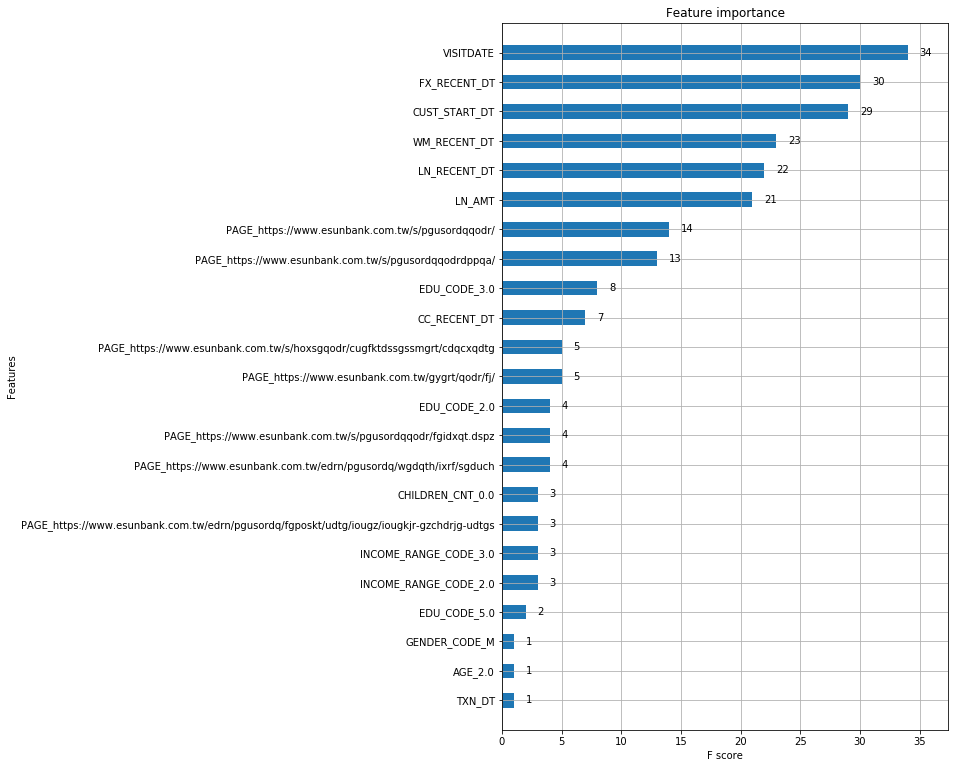

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=30, height=0.5, ax=ax)

In [70]:
if test.shape[1]>X_train1.shape[1]:
    test=test.drop('y',axis=1)

In [71]:
model.predict(test)
test['y'] = model.predict(test)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [72]:
test.shape

(198213, 770)

In [73]:
test.head()

,CC_RECENT_DT,CUST_START_DT,FX_RECENT_DT,LN_AMT,LN_RECENT_DT,TXN_DT,VISITDATE,WM_RECENT_DT,AGE_1.0,AGE_2.0,...,PAGE_https://www.esunbank.com.tw/s/wgdqthcdqcxqdtkor/,PAGE_https://www.esunbank.com.tw/s/wgdqthcdqcxqdtkor/gsxruoeot,PAGE_https://www.esunbank.com.tw/s/wgdqthcdqcxqdtkor/gsxruoeot/,WORK_MTHS_1.0,WORK_MTHS_2.0,WORK_MTHS_3.0,WORK_MTHS_4.0,WORK_MTHS_5.0,WORK_MTHS_None,y
CUST_NO,,,,,,,,,,,,,,,,,,,,,
_PT5HFBEZJKOZ934,8658.0,2912.0,0.0,0.0,0.0,0.0,9553,0.0,0,0,...,0,0,0,1,0,0,0,0,0,False
_PT5HFBEZJKOZ934,8658.0,2912.0,0.0,0.0,0.0,0.0,9553,0.0,0,0,...,0,0,0,1,0,0,0,0,0,False
_PT5HFBEZJKOZ934,8658.0,2912.0,0.0,0.0,0.0,0.0,9553,0.0,0,0,...,0,0,0,1,0,0,0,0,0,False
_PT5HFBEZJKOZ934,8658.0,2912.0,0.0,0.0,0.0,0.0,9554,0.0,0,0,...,0,0,0,1,0,0,0,0,0,False
_PT5HFBEZJKOZ934,8658.0,2912.0,0.0,0.0,0.0,0.0,9562,0.0,0,0,...,0,0,0,1,0,0,0,0,0,False


In [74]:
test.groupby(test.index).max().shape

(30000, 770)

In [75]:
# 查看 test 資料預測為 True的數量
y_final = test.groupby(test.index, sort=False).max()
print(y_final[y_final['y']==True].shape[0])
y_final[y_final['y']==True]

2375


,CC_RECENT_DT,CUST_START_DT,FX_RECENT_DT,LN_AMT,LN_RECENT_DT,TXN_DT,VISITDATE,WM_RECENT_DT,AGE_1.0,AGE_2.0,...,PAGE_https://www.esunbank.com.tw/s/wgdqthcdqcxqdtkor/,PAGE_https://www.esunbank.com.tw/s/wgdqthcdqcxqdtkor/gsxruoeot,PAGE_https://www.esunbank.com.tw/s/wgdqthcdqcxqdtkor/gsxruoeot/,WORK_MTHS_1.0,WORK_MTHS_2.0,WORK_MTHS_3.0,WORK_MTHS_4.0,WORK_MTHS_5.0,WORK_MTHS_None,y
CUST_NO,,,,,,,,,,,,,,,,,,,,,
MW2AVCUSFTILPK7S,8310.0,8316.0,0.0,0.0,8345.0,0.0,9566,0.0,0,1,...,0,0,0,1,0,0,0,0,0,True
RLWI-BTQOOPVKDJW,7222.0,5019.0,0.0,0.0,8806.0,0.0,9563,0.0,0,0,...,0,0,0,1,0,0,0,0,0,True
ZLVKIEVO5QTEFR_C,9186.0,8251.0,0.0,0.0,0.0,0.0,9562,0.0,0,1,...,0,0,0,1,0,0,0,0,0,True
KOZDVDNSELNEOYUI,0.0,9406.0,0.0,0.0,0.0,0.0,9557,0.0,1,0,...,0,0,0,0,0,0,0,0,1,True
L6CZ9QPJFHZL22BI,8360.0,2730.0,0.0,0.0,9357.0,0.0,9558,0.0,0,0,...,0,0,0,1,0,0,0,0,0,True
FESPUGMORKUVWMDE,0.0,9267.0,0.0,0.0,8051.0,0.0,9540,0.0,0,0,...,0,0,0,0,1,0,0,0,0,True
LC5EBIHVVQRF9XJE,7400.0,7397.0,0.0,0.0,8693.0,0.0,9555,0.0,1,0,...,0,0,0,1,0,0,0,0,0,True
ZXALGAPKAOIDA-0U,9309.0,7958.0,0.0,0.0,8307.0,0.0,9564,0.0,1,0,...,0,0,0,1,0,0,0,0,0,True
LMZLXOVKCIX3ZHU4,0.0,9010.0,0.0,0.0,0.0,0.0,9539,0.0,1,0,...,0,0,0,0,0,0,0,0,1,True


In [76]:
ans = pd.concat((TBN.groupby('CUST_NO').max(),y_final['y']),axis=1, join_axes=[y_final.index])
ans.head()

,CC_IND,FX_IND,LN_IND,WM_IND,y
CUST_NO,,,,,
_PT5HFBEZJKOZ934,0,0,0,0,False
6STXUMWZRDCGSDDU,0,0,0,0,False
JDVF4U8JUANEID68,0,0,0,0,False
8I6SQDGP9OQYUN1M,0,0,0,0,False
R-TRDUV3GHTID31I,0,0,0,0,False


In [77]:
ans['LN_IND']=ans['y']

In [78]:
ans = ans.drop('y', axis=1)

In [79]:
ans.to_csv('LN.csv')

In [127]:
test['y']

CUST_NO
_PT5HFBEZJKOZ934    False
_PT5HFBEZJKOZ934    False
_PT5HFBEZJKOZ934    False
_PT5HFBEZJKOZ934    False
_PT5HFBEZJKOZ934    False
_PT5HFBEZJKOZ934    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
6STXUMWZRDCGSDDU    False
JDVF4U8JUANEID68    False
JDVF4U8JUANEID68    False
JDVF4U8JUANEID68    False
JDVF4U8JUANEID68    False
JDVF4U8JUANEID68    False
JDVF4U8JUANEID68    False
8I6SQDGP9OQYUN1M    False
R-TRDUV3GHTID31I    False
R-TRDUV3GHTID31I    False
J0DDOZLDFF03QBKW    False
J0DDOZLDFF03QBKW    False
HWAZJ_IO2-GACG_C    False
                    ...  
GBGSO4CV37Q9HUGM    False
GBGSO4CV37Q9HUGM    False
GBGSO4CV37Q9HUGM    False
GBGSO4CV37Q9HUGM    False
GBGSO4CV37Q9HUGM    False
2RZMYWSGN0NOMPS4    False
2RZMYWSGN0NOMPS4    False
2RZM